In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"badiebahida","key":"cf53ac16eee55e3f97b83e289e16fc0e"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Télécharger le dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d plantvillage

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 97% 1.98G/2.04G [00:21<00:02, 25.2MB/s]
100% 2.04G/2.04G [00:21<00:00, 103MB/s] 


In [ ]:
# Préparation des données
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 32
data_dir = '/content/plantvillage/plantvillage dataset/color'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


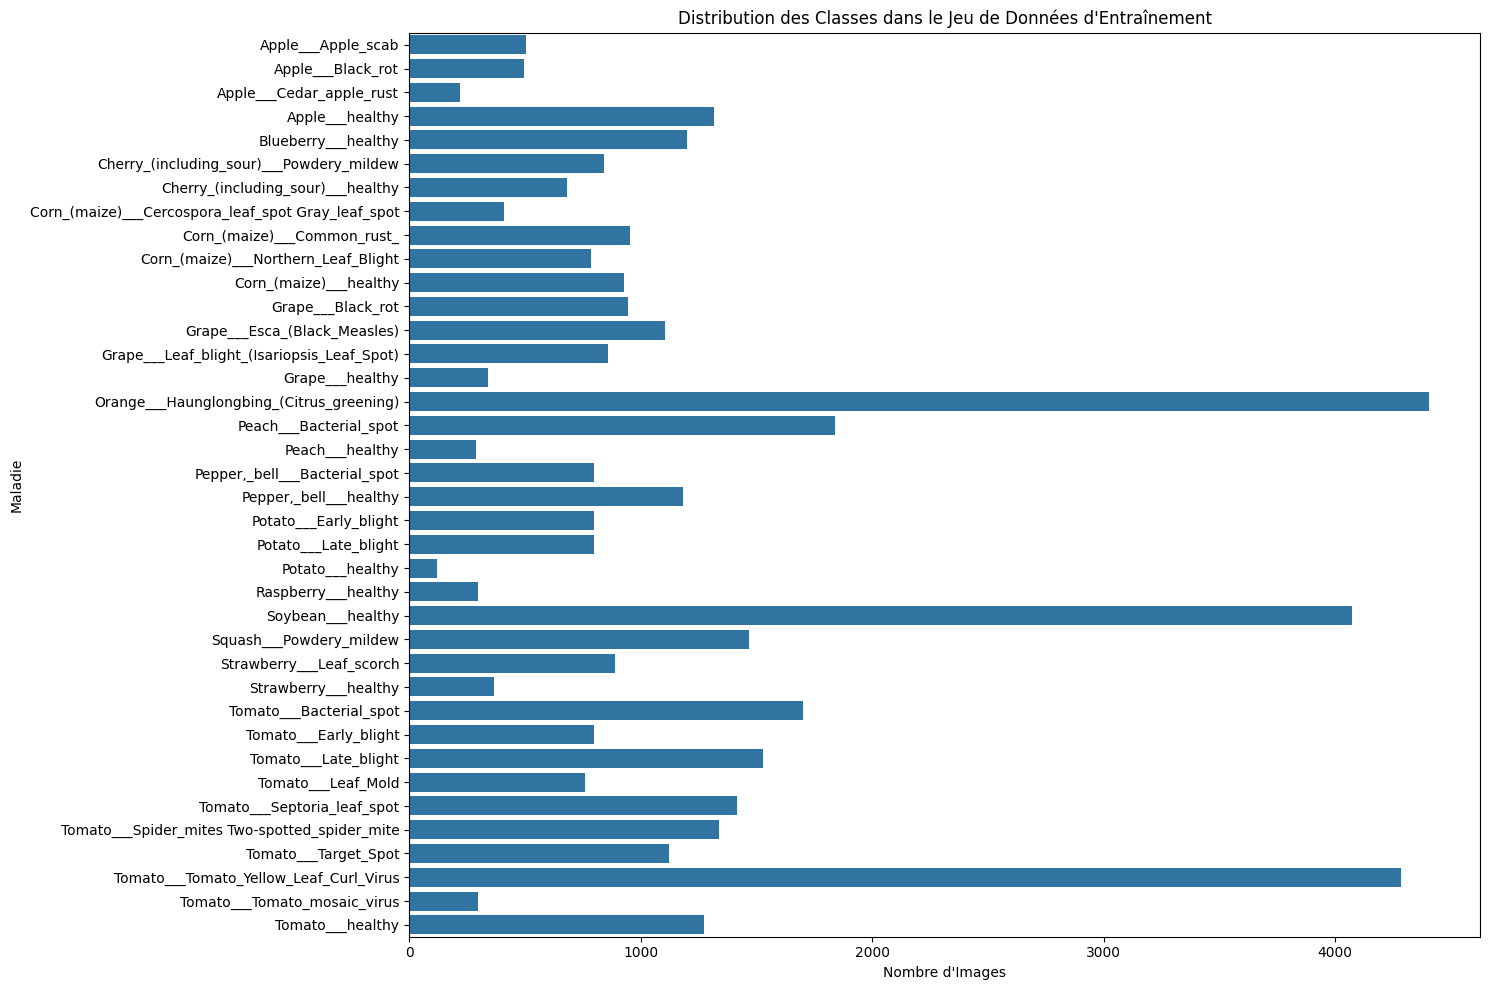

Top 5 des classes avec le plus d'images:
- Tomato___Bacterial_spot: 1702 images
- Peach___Bacterial_spot: 1838 images
- Soybean___healthy: 4072 images
- Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286 images
- Orange___Haunglongbing_(Citrus_greening): 4406 images

Top 5 des classes avec le moins d'images:
- Potato___healthy: 122 images
- Apple___Cedar_apple_rust: 220 images
- Peach___healthy: 288 images
- Raspberry___healthy: 297 images
- Tomato___Tomato_mosaic_virus: 299 images


In [ ]:
import seaborn as sns
import os

# Obtenir les noms des classes et le nombre d'images par classe
class_names = list(train_generator.class_indices.keys())
class_counts = np.bincount(train_generator.classes)

# Créer le répertoire si il n'existe pas
output_dir = '/content/drive/MyDrive/PhytoVigil'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Créer un graphique à barres pour visualiser la distribution
plt.figure(figsize=(15, 10))
sns.barplot(x=class_counts, y=class_names)
plt.title('Distribution des Classes dans le Jeu de Données d\'Entraînement')
plt.xlabel('Nombre d\'Images')
plt.ylabel('Maladie')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'distribution_classes.png'))
plt.show()

# Afficher les 5 classes avec le plus et le moins d'images
print("Top 5 des classes avec le plus d'images:")
for i in np.argsort(class_counts)[-5:]:
    print(f"- {class_names[i]}: {class_counts[i]} images")

print("\nTop 5 des classes avec le moins d'images:")
for i in np.argsort(class_counts)[:5]:
    print(f"- {class_names[i]}: {class_counts[i]} images")

In [ ]:
# Construire le modèle
num_classes = len(train_generator.class_indices)
print(f"Nombre de classes détectées : {num_classes}")

base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

Nombre de classes détectées : 38
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compiler et entraîner le modèle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Entraîner le modèle
epochs=10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6205 - loss: 1.4069

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 693s 502ms/step - accuracy: 0.6205 - loss: 1.4065 - val_accuracy: 0.8886 - val_loss: 0.3611
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 716s 487ms/step - accuracy: 0.8435 - loss: 0.4948 - val_accuracy: 0.9068 - val_loss: 0.2945
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 685s 490ms/step - accuracy: 0.8610 - loss: 0.4401 - val_accuracy: 0.9111 - val_loss: 0.2758
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 675s 485ms/step - accuracy: 0.8660 - loss: 0.4203 - val_accuracy: 0.9122 - val_loss: 0.2743
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 667s 491ms/step - accuracy: 0.8676 - loss: 0.4225 - val_accuracy: 0.9090 - val_loss: 0.2656
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 667s 491ms/step - accuracy: 0.8698 - loss: 0.4159 - val_accuracy: 0.9138 - val_loss: 0.2620
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 673s 484ms/step - accuracy: 0.8743 - loss: 0.4014 - val_accuracy: 0.9268 - val_loss: 0.2332
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 646s 475ms/step - accuracy: 0.8

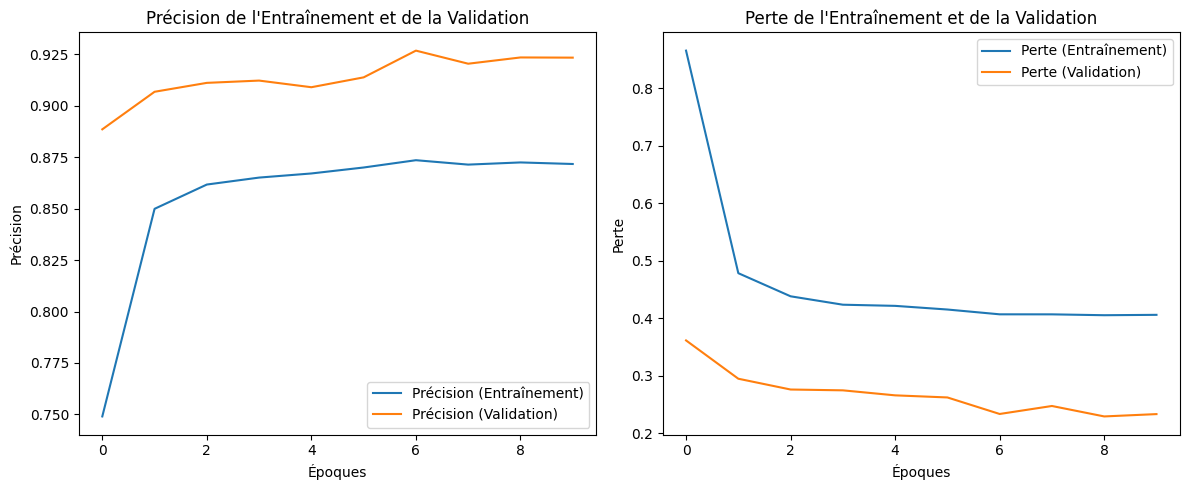

In [ ]:
# Extraire l'historique de l'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Créer les graphiques
plt.figure(figsize=(12, 5))

# Graphique de la Précision (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision (Entraînement)')
plt.plot(epochs_range, val_acc, label='Précision (Validation)')
plt.legend(loc='lower right')
plt.title('Précision de l\'Entraînement et de la Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')

# Graphique de la Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte (Entraînement)')
plt.plot(epochs_range, val_loss, label='Perte (Validation)')
plt.legend(loc='upper right')
plt.title('Perte de l\'Entraînement et de la Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PhytoVigil/performance_modele.png')
plt.show()

340/340 ━━━━━━━━━━━━━━━━━━━━ 141s 414ms/step


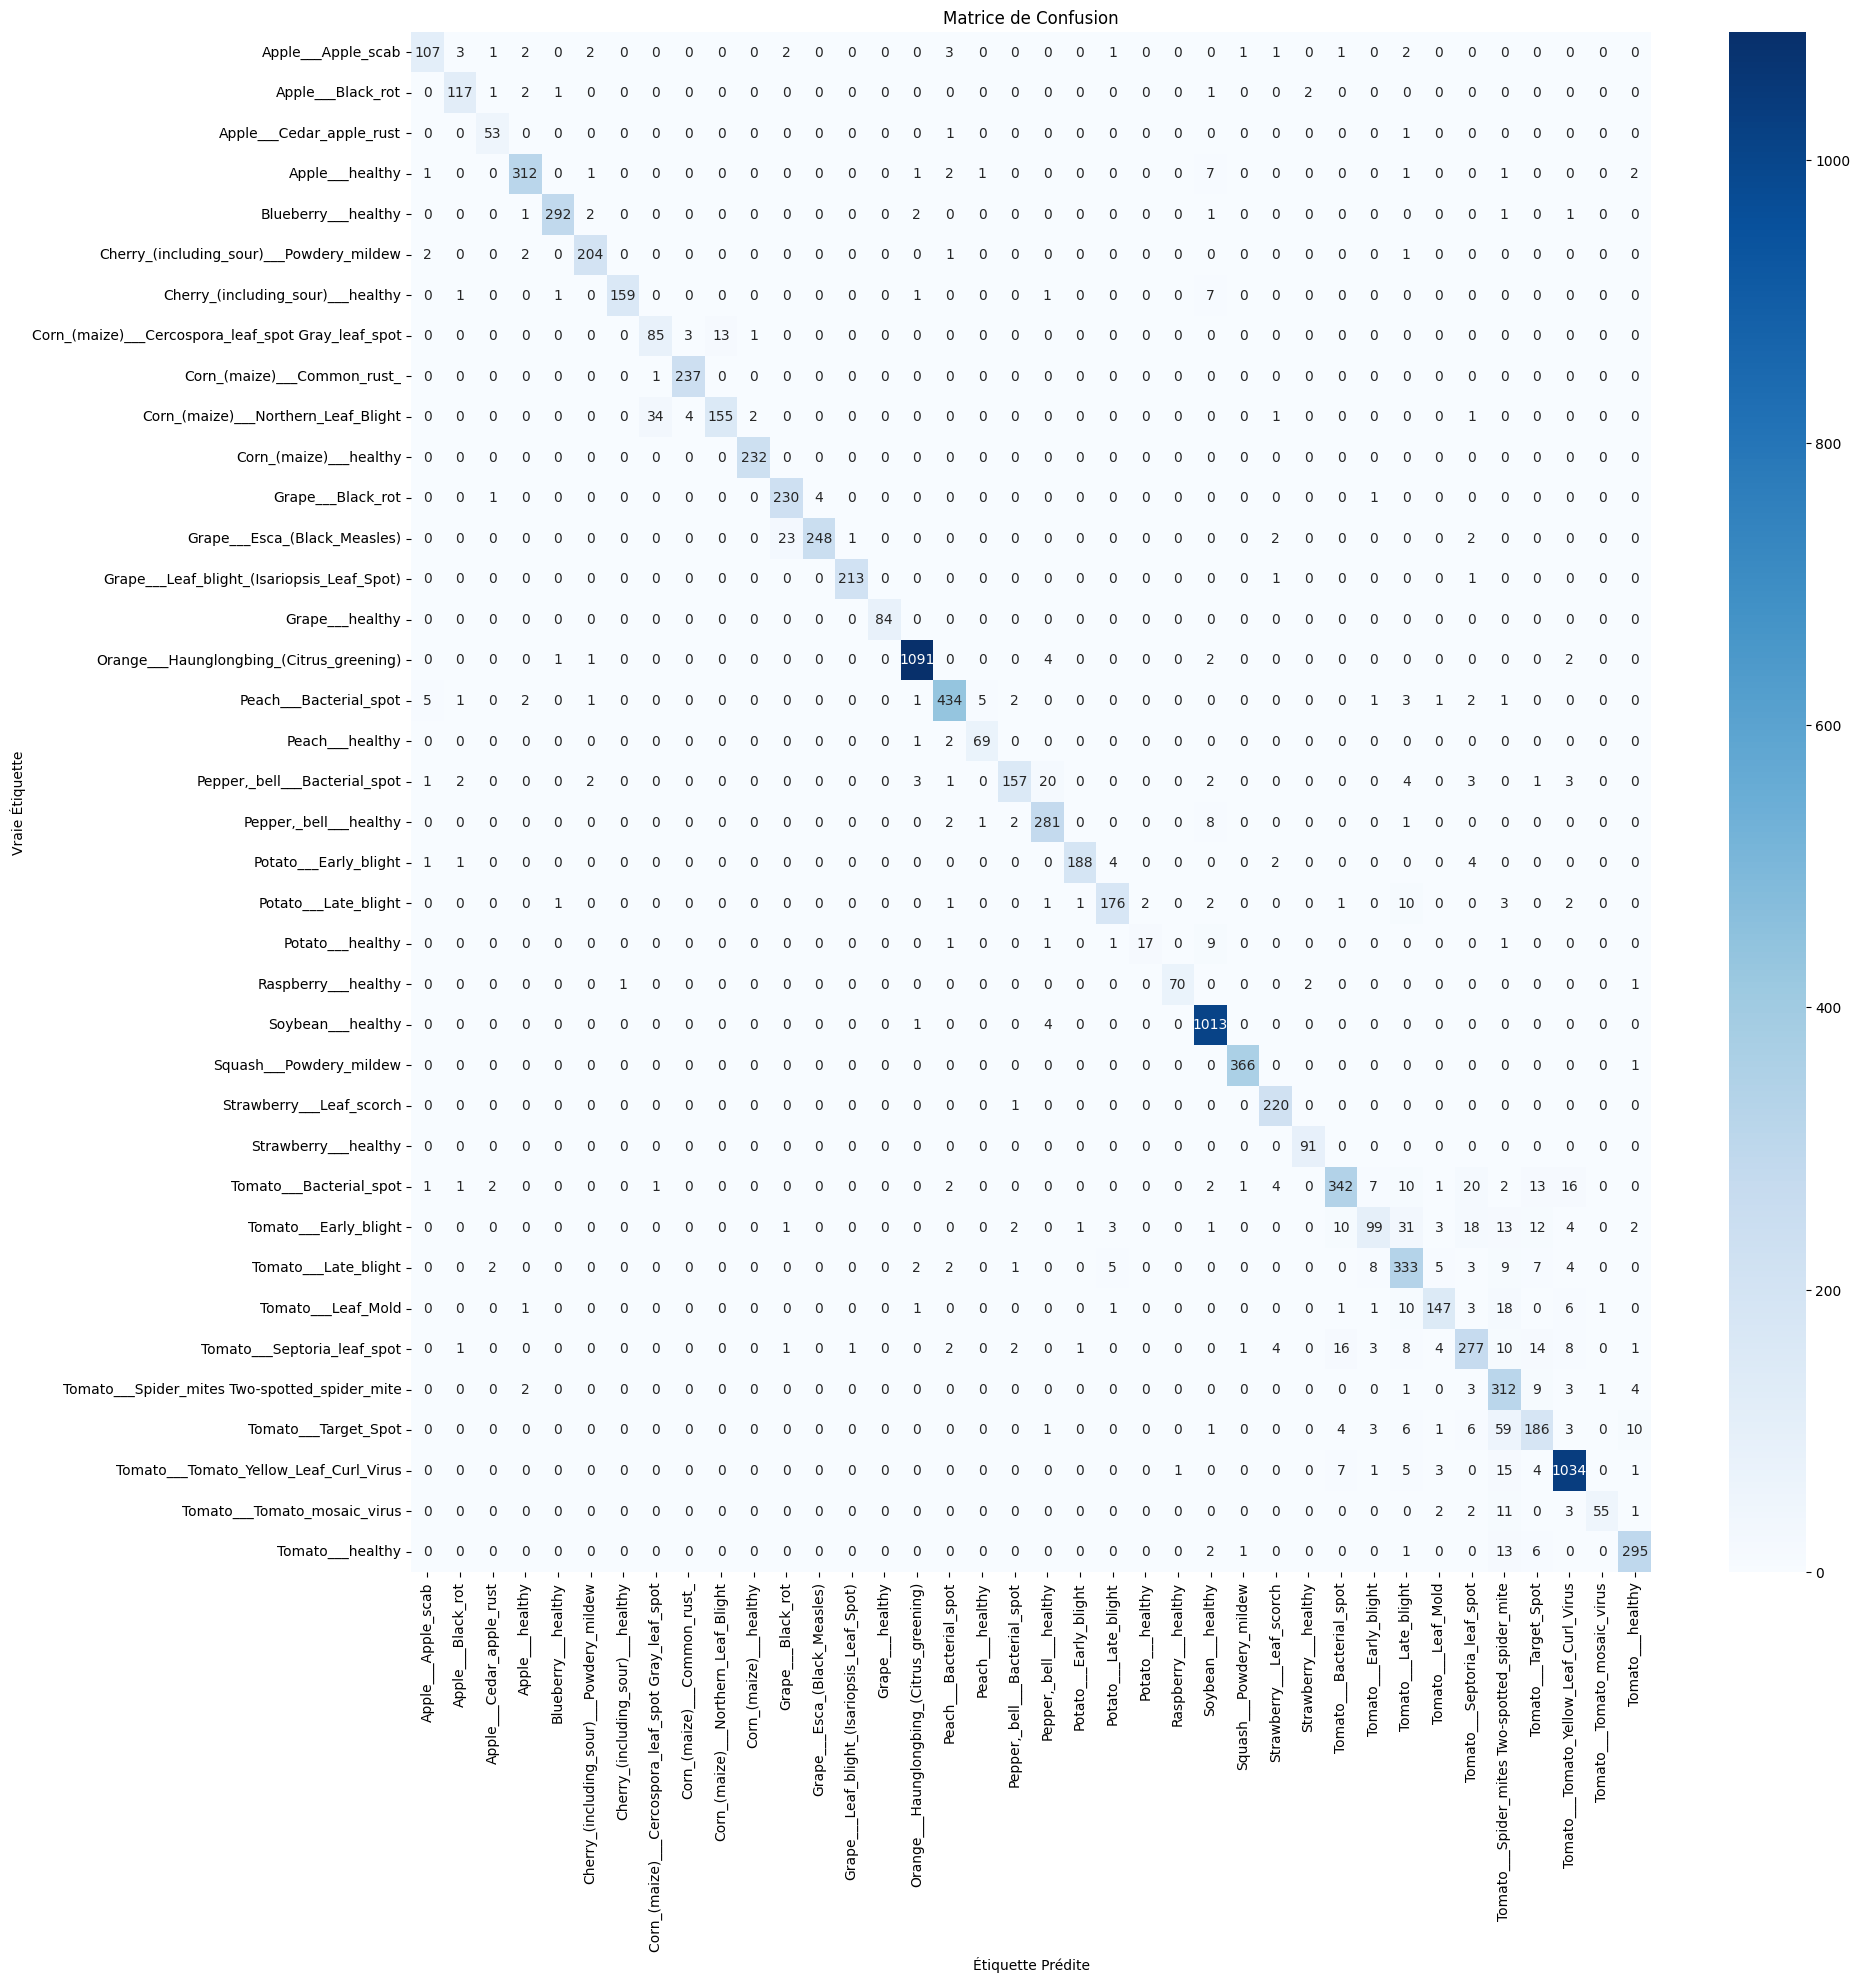

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Faire des prédictions sur l'ensemble de la validation
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Obtenir les vraies étiquettes
y_true = validation_generator.classes

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de manière visuelle
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Étiquette Prédite")
plt.ylabel("Vraie Étiquette")
plt.title("Matrice de Confusion")
plt.savefig('/content/drive/MyDrive/PhytoVigil/confusion_matrix.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Rapport de Classification :\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

with open('/content/drive/MyDrive/PhytoVigil/classification_report.txt', 'w') as f:
    f.write(report)

Rapport de Classification :

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.85      0.88       126
                                 Apple___Black_rot       0.92      0.94      0.93       124
                          Apple___Cedar_apple_rust       0.88      0.96      0.92        55
                                   Apple___healthy       0.96      0.95      0.96       329
                               Blueberry___healthy       0.99      0.97      0.98       300
          Cherry_(including_sour)___Powdery_mildew       0.96      0.97      0.96       210
                 Cherry_(including_sour)___healthy       0.99      0.94      0.96       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.70      0.83      0.76       102
                       Corn_(maize)___Common_rust_       0.97      1.00      0.98       238
               Corn_(maize)___Northern_Leaf_Blight

In [ ]:
# Évaluer le modèle (calcul du vrai nombre d’erreurs)
validation_generator.reset()

preds = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes

errors = np.sum(predicted_classes != true_classes)
print(f"Nombre total d'erreurs sur la validation : {errors} / {len(true_classes)}")
print(f"Taux d'erreur : {errors / len(true_classes):.2%}")


340/340 ━━━━━━━━━━━━━━━━━━━━ 134s 395ms/step
Nombre total d'erreurs sur la validation : 859 / 10849
Taux d'erreur : 7.92%


In [ ]:
# Afficher 9 erreurs au hasard
plt.figure(figsize=(15, 15))

# Find the indices of errors
error_indices = np.where(predicted_classes != true_classes)[0]

# Create index to label mapping
index2label = {v: k for k, v in validation_generator.class_indices.items()}

# Get filenames from the validation generator
fnames = validation_generator.filenames

# Ensure we don't try to plot more errors than exist
num_plots = min(9, len(error_indices))

if num_plots > 0:
    # Select random error indices to display
    display_indices = np.random.choice(error_indices, size=num_plots, replace=False)

    for i in range(num_plots):
        err_index = display_indices[i]

        # Construct the full path to the image
        image_path = os.path.join(data_dir, fnames[err_index])

        # Load the image
        image = tf.keras.preprocessing.image.load_img(
            image_path,
            target_size=(IMG_SIZE, IMG_SIZE)
        )

        # Prepare the subplot
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)

        # Title of the subplot
        predicted_label = index2label[y_pred[err_index]]
        true_label = index2label[y_true[err_index]] # Use y_true instead of ground_truth
        plt.title(f"Prédit : {predicted_label}\nRéel : {true_label}", color='red', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/PhytoVigil/erreurs_prediction.png')
    plt.show()
else:
    print("No errors to display.")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import json
model.save('/content/drive/MyDrive/PhytoVigil/models/plant_model.h5')
class_names = list(train_generator.class_indices.keys())
with open('/content/drive/MyDrive/PhytoVigil/models/class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Le modèle 'plant_disease_model.h5' et les classes 'class_names.json' sont sauvegardés.")

Le modèle 'plant_disease_model.h5' et les classes 'class_names.json' sont sauvegardés.
